## Load Libraries 

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from warnings import filterwarnings
filterwarnings(action='ignore')

# Dataset : Movielens
https://grouplens.org/datasets/movielens/100k

In [2]:
# Reading ratings file
ratings = pd.read_csv('https://raw.githubusercontent.com/kriti818/chatbot/main/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('https://raw.githubusercontent.com/kriti818/chatbot/main/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [3]:
df_movies = movies 
df_ratings = ratings 

## Exploratory Data Analysis(EDA)

In [4]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of movie released

<BarContainer object of 19 artists>

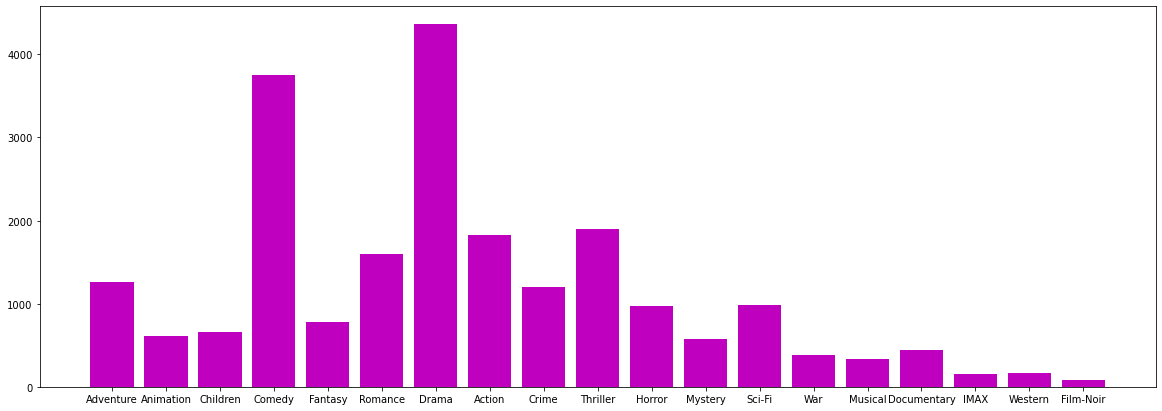

In [5]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

In [6]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Distribution of users rating

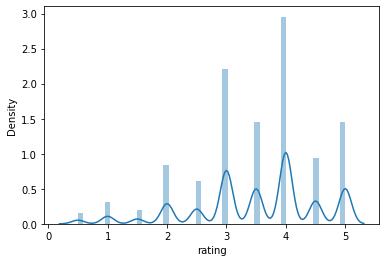

In [7]:
sns.distplot(df_ratings["rating"]);

In [8]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


In [9]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [10]:
merge_ratings_movies.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962


In [11]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

In [12]:
merge_ratings_movies.shape

(100836, 5)

Grouping the rating based on user

In [13]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])

In [14]:
ratings_grouped_by_users.head(2)

movieId               rating          
          size          mean   size      mean
userId                                       
1          232   1854.603448    232  4.366379
2           29  70350.275862     29  3.948276

In [15]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)

### Top 10 users who have rated most of the movies

In [16]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movieId').agg([np.mean], np.size)

In [17]:
ratings_grouped_by_movies.shape

(9724, 2)

In [18]:
ratings_grouped_by_movies.head(3)

,userId,rating
,mean,mean
movieId,,
1,306.530233,3.920930
2,329.554545,3.431818
3,283.596154,3.259615


In [19]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)

 Content based filtering

In [20]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
df_movies['genres'] = df_movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(df_movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [21]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = df_movies.loc[df_movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:10]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return df_movies['title'].iloc[movie_indices]


In [22]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

17                         Four Rooms (1995)
18     Ace Ventura: When Nature Calls (1995)
58                           Bio-Dome (1996)
61                             Friday (1995)
79                        Black Sheep (1996)
90                          Mr. Wrong (1996)
92                      Happy Gilmore (1996)
104           Steal Big, Steal Little (1995)
108            Flirting With Disaster (1996)
Name: title, dtype: object

In [23]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = df_ratings[df_ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((df_movies["title"][row["movieId"]==df_movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

{'*batteries not included (1987)',
 '101 Dalmatians (One Hundred and One Dalmatians) (1961)',
 '10th Kingdom, The (2000)',
 '13 Going on 30 (2004)',
 '39 Steps, The (1935)',
 '48 Hrs. (1982)',
 '5,000 Fingers of Dr. T, The (1953)',
 '52 Pick-Up (1986)',
 '8MM (1999)',
 'A Wrinkle in Time (2018)',
 'Absolute Power (1997)',
 'Ace Ventura: When Nature Calls (1995)',
 'Action Jackson (1988)',
 'Adventures in Babysitting (1987)',
 'Adventures of Baron Munchausen, The (1988)',
 'Adventures of Buckaroo Banzai Across the 8th Dimension, The (1984)',
 'Adventures of Ichabod and Mr. Toad, The (1949)',
 'Adventures of Pinocchio, The (1996)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Adventures of Sharkboy and Lavagirl 3-D, The (2005)',
 'Agent Cody Banks (2003)',
 'Aladdin (1992)',
 'Alamo, The (1960)',
 'Alaska (1996)',
 'Alice (1990)',
 'Alice in Wonderland (1951)',
 'Alien Nation (1988)',
 'All Dogs Christmas Carol, An (1998)',
 'All Dogs Go to Heaven 2 (1996)',
 'All That Jazz (1979

# Model evaluation with KNN
Here the model is evaluated on based of if there is exact match of genres with the genres of movie which is already watch by user 

In [24]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = df_movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [25]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in df_movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
#                 print(colums["genres"])
#                 print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))
print("Accuracy:"+str(true_count/total))

Hit:0.8840986336367161
Fault:0.11590136636328384
Accuracy:0.8840986336367161


In [26]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [27]:
df_movies = movies 
df_ratings = ratings 

 Collaborative Filtering

## Implementation of Item-Item Filtering

In [28]:
df_movies_ratings=pd.merge(df_movies, df_ratings)

In [29]:
df_movies_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


Here Pivot table function is used as we want one to one maping between movies, user and their rating. 
So by default pivot_table command takes average if we have multiple values of one combination.

In [30]:
ratings_matrix_items = df_movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [31]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items


,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


Below function will take the movie name as a input and will find the movies which are similar to this movie.
This function first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe so that we can get the similarity of the movie with all other movies.

In [33]:
def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=df_movies[df_movies['title']==user_inp].index.tolist()
        inp=inp[0]

        df_movies['similarity'] = ratings_matrix_items.iloc[inp]
        df_movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [34]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user_movie= df_movies_ratings[(df_movies_ratings.userId==user_id) & df_movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=df_movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= df_ratings[df_ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= df_ratings[(df_ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [35]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(df_movies[df_movies['movie_id']==id]['title'])
    return movie_titles

In [36]:
user_id=50
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [659    Godfather, The (1972)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 922    Godfather: Part II, The (1974)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 659    Godfather, The (1972)
Name: title, dtype: object, 1644    Willow (1988)
Name: title, dtype: object]


## Implementation of User-Item Filtering

In similar way as we did for ItemItem similarity we will create a matrix but here we will keep rows as user and columns as movieId as we want a vector of different users.
Then in similar ways we will find distance and similarity between users.

In [37]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users


,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [38]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [39]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 10 )

547     76
241    467
277    337
348    454
218    238
407    278
352     45
97     600
381     20
607    479
dtype: int64

In [40]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()

In [41]:
df_similar_user.columns=['similarUser']

In [42]:
df_similar_user

,similarUser
0,265
1,365
2,312
3,390
4,469
...,...
605,473
606,569
607,479
608,339


Below function takes id of the user to whom we have to recommend movies. On basis of that, we find the user which is similar to that user and then filter the movies which are highly rated by the user to recommend them to given user.

In [43]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [44]:
user_id=50
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object]


# Evaluating the model

In [45]:
def get_user_similar_movies( user1, user2 ):
    
    """
     Returning common movies and ratings of same for both the users
    :param user1,user2: user ids of 2 users need to compare
    :return: movieIds to user 
    """
    common_movies = df_movies_ratings[df_movies_ratings.userId == user1].merge(
      df_movies_ratings[df_movies_ratings.userId == user2],
      on = "movieId",
      how = "inner" )
    common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
    return common_movies

In [46]:
get_user_similar_movies(587,511)

,title_x,userId_x,rating_x,userId_y,rating_y
0,Forrest Gump (1994),587,4.0,511,4.5
1,Life Is Beautiful (La Vita Ã¨ bella) (1997),587,5.0,511,4.5
2,"Matrix, The (1999)",587,4.0,511,5.0


# Single Value Decomposition

In [47]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('https://raw.githubusercontent.com/kriti818/chatbot/main/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading users file
#users = pd.read_csv('users.dat', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('https://raw.githubusercontent.com/kriti818/chatbot/main/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [48]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 610 | Number of movies = 9724


In [49]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, we need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [50]:
R = Ratings.to_numpy()
#print(R)
user_ratings_mean = np.mean(R, axis = 1)
#print(user_ratings_mean.shape)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) ## Making the user_ratings_mean vertical by reshaping


610


In [51]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens100K dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens100K dataset is 98.3%


## Setting Up SVD

In [52]:
from scipy.sparse.linalg import svds 

In [53]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [54]:
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


In [55]:
sigma = np.diag(sigma)

In [56]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 67.86628347   0.           0.         ...   0.           0.
    0.        ]
 [  0.          68.1967072    0.         ...   0.           0.
    0.        ]
 [  0.           0.          69.02678246 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 184.86187801   0.
    0.        ]
 [  0.           0.           0.         ...   0.         231.22453421
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  474.20606204]]


In [57]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (610, 50)
Shape of Vt:  (50, 9724)


## Making Predictions from the Decomposed Matrices

In [58]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [59]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (610, 9724)


In [60]:
print('Rating Dataframe column names', Ratings.columns)

Rating Dataframe column names Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)


In [61]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127


In [62]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 150.

In [63]:
already_rated, predictions = recommend_movies(preds, 150, movies, ratings, 20)

User 150 has already rated 26 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [64]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres
25,150,1356,5.0,854203229,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller
5,150,32,5.0,854203071,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
12,150,141,5.0,854203072,"Birdcage, The (1996)",Comedy
17,150,648,4.0,854203072,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
2,150,6,4.0,854203123,Heat (1995),Action|Crime|Thriller
4,150,25,4.0,854203072,Leaving Las Vegas (1995),Drama|Romance
6,150,36,4.0,854203123,Dead Man Walking (1995),Crime|Drama
7,150,52,4.0,854203163,Mighty Aphrodite (1995),Comedy|Drama|Romance
23,150,805,4.0,854203230,"Time to Kill, A (1996)",Drama|Thriller
20,150,780,4.0,854203071,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


In [65]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,movieId,title,genres
574,736,Twister (1996),Action|Adventure|Romance|Thriller
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
211,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
607,802,Phenomenon (1996),Drama|Romance
12,17,Sense and Sensibility (1995),Drama|Romance
87,112,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime
558,708,"Truth About Cats & Dogs, The (1996)",Comedy|Romance
599,788,"Nutty Professor, The (1996)",Comedy|Fantasy|Romance|Sci-Fi
886,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
634,852,Tin Cup (1996),Comedy|Drama|Romance


## Model Evaluation

Can't forget to evaluate our model, can we?

Instead of doing manually like the last time, we will use the Surprise library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.

In [66]:
!pip install scikit-surprise

In [67]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.metrics import accuracy_score

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset for 5-fold evaluation


In [68]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.


In [69]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8731  0.8823  0.8715  0.8783  0.8629  0.8736  0.0066  
MAE (testset)     0.6701  0.6767  0.6687  0.6737  0.6658  0.6710  0.0038  
Fit time          5.59    5.26    5.27    5.56    5.25    5.39    0.15    
Test time         0.14    0.13    0.14    0.13    0.13    0.13    0.01    


{'test_rmse': array([0.87305059, 0.88225069, 0.87146716, 0.87833553, 0.8628715 ]),
 'test_mae': array([0.67009508, 0.67670757, 0.66873255, 0.67368514, 0.66582562]),
 'fit_time': (5.585079669952393,
  5.2629265785217285,
  5.270906209945679,
  5.562153577804565,
  5.245974779129028),
 'test_time': (0.1405317783355713,
  0.12569642066955566,
  0.13962769508361816,
  0.1316211223602295,
  0.13467097282409668)}

We get a mean Root Mean Square Error of  0.87 which is pretty good. Let's now train on the dataset and arrive at predictions.

In [70]:
trainset = data.build_full_trainset()
#svd.train(trainset)

We will pick again user with ID 150 and check the ratings he has given.

In [71]:
ratings[ratings['userId'] == 150]

,userId,movieId,rating,timestamp
22277,150,3,3.0,854203124
22278,150,5,3.0,854203124
22279,150,6,4.0,854203123
22280,150,7,3.0,854203124
22281,150,25,4.0,854203072
22282,150,32,5.0,854203071
22283,150,36,4.0,854203123
22284,150,52,4.0,854203163
22285,150,58,3.0,854203163
22286,150,62,3.0,854203072


Now let's use SVD to predict the rating that User with ID 150 will give to a random movie (let's say with Movie ID 1994).

In [72]:
svd.predict(150, 1994)

Prediction(uid=150, iid=1994, r_ui=None, est=3.7018194019244364, details={'was_impossible': False})

For movie with ID 1994, I get an estimated prediction of 3.18210. The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

In [73]:
svd.predict(150, 100)

Prediction(uid=150, iid=100, r_ui=None, est=3.0567477898954944, details={'was_impossible': False})

In [74]:
svd.predict(150, 194)

Prediction(uid=150, iid=194, r_ui=None, est=3.7522543539029147, details={'was_impossible': False})

In [75]:
svd.predict(150, 190)

Prediction(uid=150, iid=190, r_ui=None, est=3.272811994650532, details={'was_impossible': False})

In [76]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import SVDpp
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
import time


In [77]:
# Use movielens-100K
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.15)

type(data)

surprise.dataset.DatasetAutoFolds

In [78]:
def recommendation(algo, trainset, testset):
  # Train the algorithm on the trainset, and predict ratings for the testset
  start_fit = time.time()
  algo.fit(trainset)
  end_fit = time.time()
  fit_time = end_fit - start_fit
  start_test = time.time()
  predictions = algo.test(testset)
  
  end_test = time.time()
  test_time = end_test - start_test
  # Then compute RMSE
  
  accuracy.rmse(predictions)
  # Then compute MAE
  accuracy.mae(predictions)
  return

In [79]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9385
MAE:  0.7418
Done!


In [80]:
sim_options = {'name': 'cosine'}
algo = KNNBaseline(sim_options=sim_options)
recommendation(algo, trainset, testset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9310
MAE:  0.7378


In [81]:
sim_options = {'name': 'pearson',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)
recommendation(algo, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9368
MAE:  0.7404


In [82]:
# basic collaborative filtering algorithm taking into account a baseline rating.
sim_options = {'name': 'pearson'}
algo = KNNBaseline(sim_options=sim_options)
recommendation(algo, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9273
MAE:  0.7323


In [83]:
algo = KNNBasic()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9811
MAE:  0.7772
Done!


In [84]:
algo = KNNBaseline()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9284
MAE:  0.7348
Done!


In [85]:
algo = KNNWithMeans()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9499
MAE:  0.7507
Done!


In [86]:
algo = KNNWithZScore()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9507
MAE:  0.7478
Done!


In [87]:
algo = CoClustering()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

RMSE: 0.9768
MAE:  0.7663
Done!


In [88]:
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

RMSE: 0.9301
MAE:  0.7353
Done!


In [89]:
algo_svdpp = SVDpp(n_factors=160, n_epochs=10, lr_all=0.005, reg_all=0.1)
algo_svdpp.fit(trainset)
test_pred = algo_svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.rmse(test_pred, verbose=True)
accuracy.mae(test_pred)
print("Done!")

SVDpp : Test Set
RMSE: 0.9441
MAE:  0.7528
Done!


In [90]:
algo = NMF()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)
accuracy.mae(predictions)
print("Done!")

RMSE: 0.9605
MAE:  0.7580
Done!


In [91]:
surprise_df = pd.DataFrame(columns= ['Algorithm', 'rmse', 'mae', 'fit_time', 'test_time'])

We have explored and used Surprise package:
This package has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of CF algorithms.



# Evaluating Collaborative Filtering

***Hit Ratio***
It is ratio of number of hits/ Total recommendation

In [93]:
user_id=50

In [94]:
def evaluation_collaborative_svd_model(userId,userOrItem):
    """
    hydrid the functionality of Collaborative based and svd based model to see if ratings of predicted movies 
    :param userId: userId of user, userOrItem is a boolean value if True it is User-User and if false Item-Item
    :return: dataframe of movies and ratings
    """ 
    movieIdsList= list()
    movieRatingList=list()
    movieIdRating= pd.DataFrame(columns=['movieId','rating'])
    if userOrItem== True:
        movieIdsList=getRecommendedMoviesAsperUserSimilarity(userId)
    else:
        movieIdsList=recommendedMoviesAsperItemSimilarity(user_id)
    for movieId in movieIdsList:
        predict = svd.predict(userId, movieId)
        movieRatingList.append([movieId,predict.est])
        movieIdRating = pd.DataFrame(np.array(movieRatingList), columns=['movieId','rating'])
        count=movieIdRating[(movieIdRating['rating'])>=3]['movieId'].count()
        total=movieIdRating.shape[0]
        hit_ratio= count/total
    return hit_ratio
    

In [95]:
print("Hit ratio of User-user collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,True))
print("Hit ratio of Item-Item collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,False))

Hit ratio of User-user collaborative filtering
0.5555555555555556
Hit ratio of Item-Item collaborative filtering
0.8888888888888888


# Hybrid model:

After developing individual models as discussed earlier, we now stack them in order to get better results.

Content Based Filtering + SVD

Steps:
1. Run Content based filtering and determine the movies which we want to recommend to the user.
2. Filter and sort the recommendations of CF using SVD predicted ratings.


In [96]:

df_movies=movies
def hybrid_content_svd_model(userId):
    """
    hydrid the functionality of content based and svd based model to recommend user top 10 movies. 
    :param userId: userId of user
    :return: list of movies recommended with rating given by svd model
    """
    recommended_movies_by_content_model = get_recommendation_content_model(userId)
    recommended_movies_by_content_model = df_movies[df_movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    for key, columns in recommended_movies_by_content_model.iterrows():
        predict = svd.predict(userId, columns["movieId"])
        recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
#         if(predict.est < 2):
#             recommended_movies_by_content_model = recommended_movies_by_content_model.drop([key])
    return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]
        
hybrid_content_svd_model(user_id)

,movieId,title,genres,svd_rating
686,904,Rear Window (1954),Mystery|Thriller,3.660277
1730,2324,Life Is Beautiful (La Vita Ã¨ bella) (1997),Comedy|Drama|Romance|War,3.625969
210,246,Hoop Dreams (1994),Documentary,3.620601
6710,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,3.570101
1503,2028,Saving Private Ryan (1998),Action|Drama|War,3.534514
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,3.498864
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,3.478209
2996,4011,Snatch (2000),Comedy|Crime|Thriller,3.449896
828,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,3.423383
3638,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,3.418120


### Conclusion

We implemented and evaluated different widely used Movie Recommendation models. Also, we developed our own models like the hybrid model (Content based + SVD) as discussed earlier. We evaluated each model with the appropriate evaluation metric.
We implemented novel technique to evaluate collaborative filtering algorithm by using SVD and hit ratio as a metric

We attempted to build a model-based Collaborative Filtering movie recommendation sytem based on latent features from a low rank matrix factorization method called SVD and SVD++. As it captures the underlying features driving the raw data, it can scale significantly better to massive datasets as well as make better recommendations based on user's tastes. For SVD model we get an RMSE of <b>0.87</b> and for SVD++ model we get an RMSE of <b>0.938</b>